In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping



In [ ]:
#Use the prepared data and create a pivot table
aggLSTM = pd.read_parquet("Data/agg_table_new_zones8Bot.parquet")
pivot_df = aggLSTM.pivot(index='time_bin', columns='h3_index', values='order_count').fillna(0)

In [3]:
# Normalize the delivery counts using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pivot_df)

In [4]:
#Now the data needs to be prepared for the LSTM by using a sliding window to use the last bins 
def create_dataset(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :])
        y.append(data[i+time_steps, :])  # Predict the next time step
    return np.array(X), np.array(y)

In [ ]:
X, y = create_dataset(scaled_data, time_steps=4) #window

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.125, shuffle=False #one day test
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split( #one day validation
    X_train_val, y_train_val, test_size=0.15, shuffle=False
)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5) # Use five folds 

for train_index, val_index in tscv.split(X_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Add dropout, deactivating 20% of neurons (against overfitting)
model.add(Dense(units=y_train.shape[1]))
model.compile(optimizer='adam', loss='mse') #ADAM optimizer and Mean squared error loss

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) #early stopping after model struggles with validation

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping]) #Train the model

Epoch 1/50
18/18 [==============================] - 2s 30ms/step - loss: 0.0316 - val_loss: 0.0220
Epoch 2/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.0146
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0131
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.0124
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 7/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 8/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 9/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 10/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 11/50
18/18 

In [ ]:
test_loss = model.evaluate(X_test, y_test) #Calculate final loss
print(f"Final Test Loss: {test_loss}")

3/3 [==============================] - 0s 2ms/step - loss: 0.0096
Final Test Loss: 0.009580375626683235


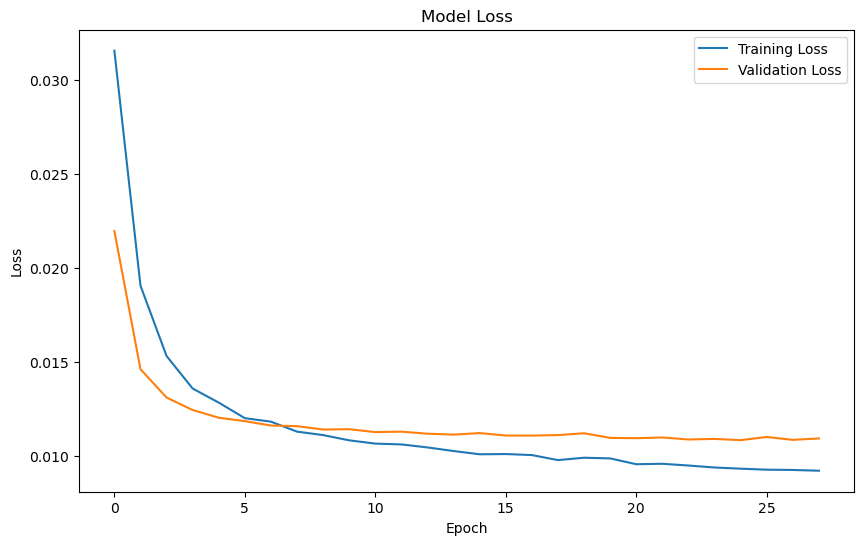

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Model the loss

In [ ]:
predictions = model.predict(X_test) #predict the values of test

3/3 [==============================] - 0s 5ms/step


In [15]:
# Step 15: Inverse transform the predictions and actual values
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

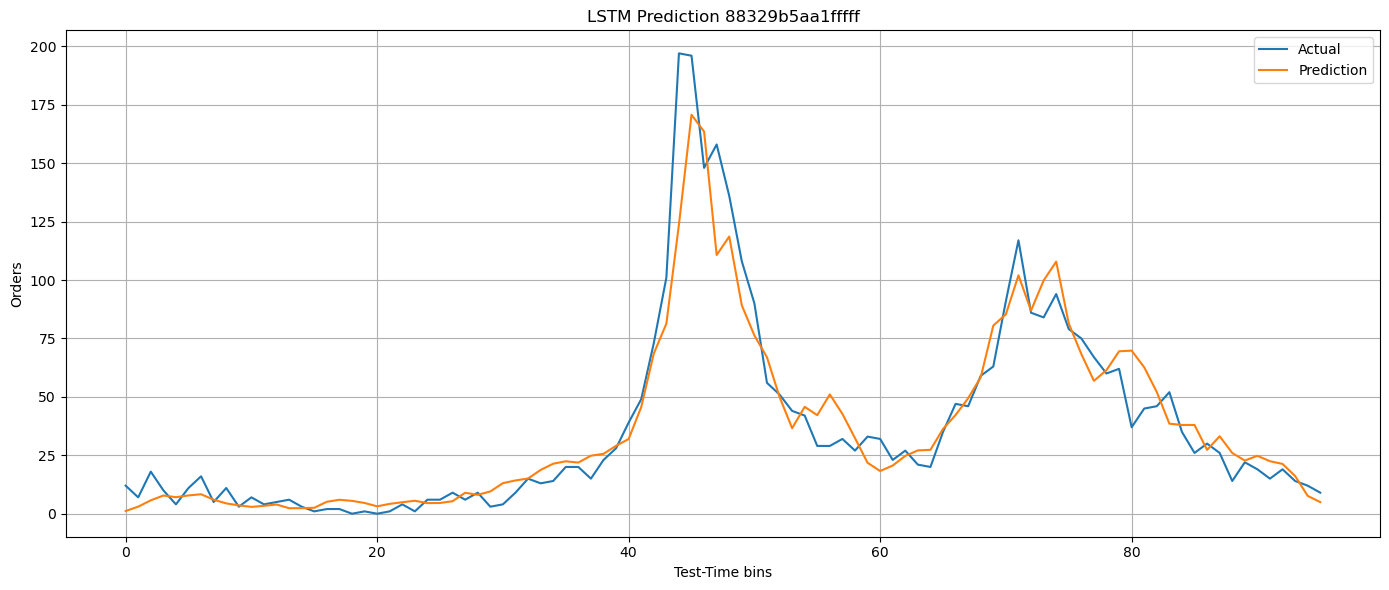

In [16]:
example_area = "88329b5aa1fffff"  # change the area to observe
example_index = pivot_df.columns.get_loc(example_area)

plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled[:, example_index], label='Actual')
plt.plot(predictions_rescaled[:, example_index], label='Prediction')
plt.title(f'LSTM Prediction {example_area}')
plt.xlabel('Test-Time bins')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Combine all
y_tests_all = np.concatenate(y_test_rescaled)
y_preds_all = np.concatenate(predictions_rescaled)

In [ ]:
#Metrics and calculations
n = len(y_tests_all)
p = X.shape[1]

rmse = np.sqrt(mean_squared_error(y_tests_all, y_preds_all))
mae = mean_absolute_error(y_tests_all, y_preds_all)
r2 = r2_score(y_tests_all, y_preds_all)
nrmse = rmse / np.mean(np.abs(y_tests_all)) * 100
nonzero_indices = y_tests_all != 0
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


if np.any(nonzero_indices):
    mape = np.mean(np.abs((y_tests_all[nonzero_indices] - y_preds_all[nonzero_indices]) / y_tests_all[nonzero_indices])) * 100
else:
    mape = np.nan

print("Evaluation:")
print(f"MAPE: {mape:.2f}%")
print(f"NRMSE: {nrmse:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"Adjusted R²: {adj_r2:.2f}")

Evaluation über alle Areas hinweg:
MAPE: 50.22%
NRMSE: 71.60%
RMSE: 3.30
MAE: 1.45
R²: 0.92
Adjusted R²: 0.92


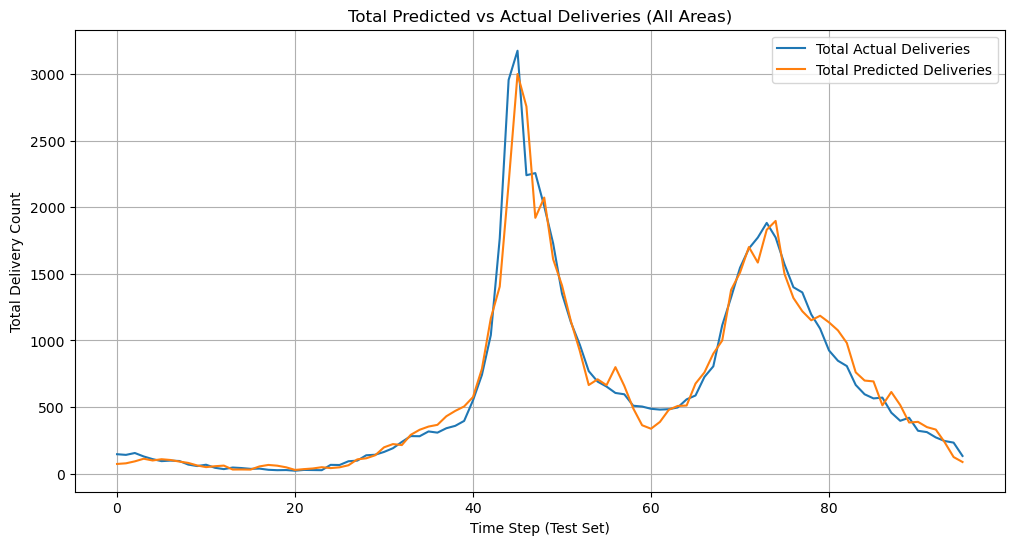

In [ ]:
# Sum of all predictions
total_actuals = y_test_rescaled.sum(axis=1)
total_predictions = predictions_rescaled.sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(total_actuals, label='Total Actual Deliveries')
plt.plot(total_predictions, label='Total Predicted Deliveries')
plt.title('Total Predicted vs Actual Deliveries (All Areas)')
plt.xlabel('Time Step (Test Set)')
plt.ylabel('Total Delivery Count')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Demand cumulated
total_actual = np.sum(y_test_rescaled, axis=1)
total_predicted = np.sum(predictions_rescaled, axis=1)

# Metrics for cumulated demand
rmse_total = np.sqrt(mean_squared_error(total_actual, total_predicted))
mae_total = mean_absolute_error(total_actual, total_predicted)
r2_total = r2_score(total_actual, total_predicted)

mask = total_actual != 0
if np.any(mask):
    mape_total = np.mean(np.abs((total_actual[mask] - total_predicted[mask]) / total_actual[mask])) * 100
else:
    mape_total = np.nan

print(f"--- Evaluation ---")
print(f"RMSE (Total): {rmse_total:.2f}")
print(f"MAE  (Total): {mae_total:.2f}")
print(f"R²   (Total): {r2_total:.2f}")
print(f"MAPE (Total): {mape_total:.2f}%")


--- Metriken für Gesamtnachfrage ---
RMSE (Total): 133.92
MAE  (Total): 78.69
R²   (Total): 0.96
MAPE (Total): 20.96%


In [ ]:
"""
Code for naive model to compare one week before 
"""
steps_per_week = 7 * 24 * 4  

test_start_idx = len(scaled_data) - len(y_test)
comparison_idx = test_start_idx - steps_per_week
y_lastweek = scaled_data[comparison_idx : comparison_idx + len(y_test)]
y_lastweek_rescaled = scaler.inverse_transform(y_lastweek)

actual = y_test_rescaled
predicted_lstm = predictions_rescaled
predicted_lastweek = y_lastweek_rescaled

rmse_lastweek = np.sqrt(mean_squared_error(actual, predicted_lastweek))

mae_lw = mean_absolute_error(actual, predicted_lastweek)
r2_lw = r2_score(actual, predicted_lastweek)
nrmse_lw = rmse_lastweek / np.mean(np.abs(y_tests_all)) * 100
nonzero_indices = actual != 0

if np.any(nonzero_indices):
    mape_lw = np.mean(np.abs((actual[nonzero_indices] - predicted_lastweek[nonzero_indices]) / actual[nonzero_indices])) * 100
else:
    mape_lw = np.nan

adj_r2_lw = 1 - (1 - r2) * (n - 1) / (n - p - 1)


print("Evaluation")
print(f"Lw MAPE: {mape_lw:.2f}%")
print(f"Lw NRMSE: {nrmse_lw:.2f}%")
print(f"Lw RMSE: {rmse_lastweek:.2f}")
print(f"Lw MAE: {mae_lw: .2f}")
print(f"Lw Adj_R²: {adj_r2_lw:.2f}")
print(f"Lw R²: {r2_lw:.2f}")

Evaluation über alle Areas hinweg Lw:
Lw MAPE: 60.00%
Lw NRMSE: 70.14%
Lw RMSE: 3.23
Lw MAE:  1.55
Lw Adj_R²: 0.92
Lw R²: 0.18


In [22]:
# Loading of other models
prognose_arima = np.load('prognose_arima.npy')
prognose_RF = np.load('prognose_RF.npy')
prognose_XGB = np.load('prognose_XGB.npy')
prognose_GCN_LSTM = np.load('prognose_GCN_LSTM.npy')



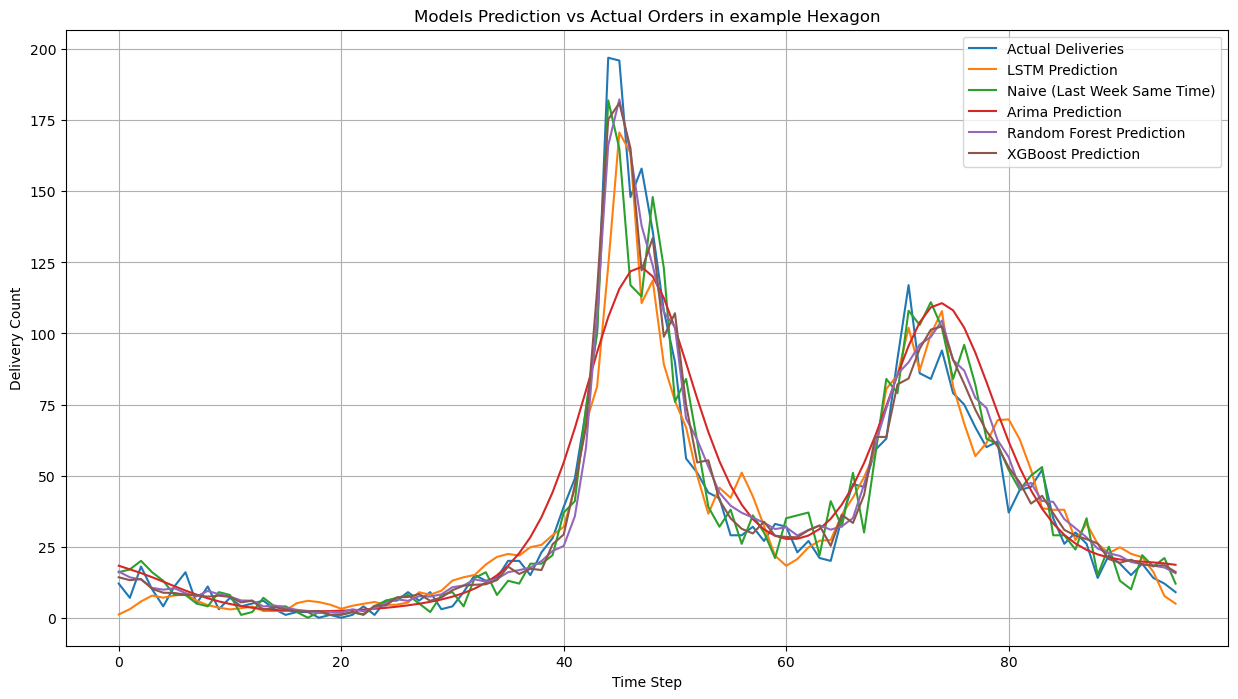

In [24]:
import os
example_area = "88329b5aa1fffff"  # change the area to observe
example_index = pivot_df.columns.get_loc(example_area)
plot_dir = "graphics"
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(15, 8))
plt.plot(actual[:, example_index], label="Actual Deliveries")
plt.plot(predicted_lstm[:, example_index], label="LSTM Prediction")
plt.plot(predicted_lastweek[:, example_index], label="Naive (Last Week Same Time)")
plt.plot(prognose_arima, label="Arima Prediction")
plt.plot(prognose_RF, label="Random Forest Prediction")
plt.plot(prognose_XGB, label="XGBoost Prediction")

plt.title("Models Prediction vs Actual Orders in example Hexagon")
plt.xlabel("Time Step")
plt.ylabel("Delivery Count")
plt.legend()
plt.grid(True)

policy_plot_filename = os.path.join(plot_dir, f"Modelpredcomparison.svg")
plt.savefig(policy_plot_filename, format='svg', bbox_inches='tight')
plt.show()

